### Tamagotchi POMCP
pam o.p. 2018
Pomagotchi (Partially observable tamagotchi)
And POMCP solution method (MCTS in PO framework)

In [121]:
# imports
from random import randint
import numpy as np
import random
import datetime # for limiting calculation to wall clock time
import math
import copy
import matplotlib.pyplot as plt


In [2]:
# tamagotchi class adapted from https://github.com/bitterfly/tamagotchi/blob/master/tamagotchi/core/tamagotchi.py

class Tamagotchi:
    def __init__(self):
        self.stats = {"food": 100, "happiness": 100, "hygiene": 100,
                 "health": 100, "energy": 100}
        self.is_sleeping = False
        self.is_dead = False
        self.is_playing = False
        self.is_sick = False
        self.number_of_poo = 0
        self.money = 0
        self.time = 0
        self.in_store = False

    #Makes sure the statistic isn't below 0 or above 100
    def constrain(self, value):
        value = min(100, value)
        value = max(0, value)
        return value

    #Constrains all the stats
    def constrain_stats(self):
        for statistic, value in self.stats.items():
            self.stats[statistic] = self.constrain(value)

    #Takes a dictionary with statistics and adds each value
    #to the tamagotchi statistics
    def apply(self, item):
#         for statistic, value in self.stats.items():
#             self.stats[statistic] += item[statistic]
        self.stats[item['stats']] += item['effect']
        self.constrain_stats()

#     #Takes a statistic and decreases it to zero in "full hours" time
    def decrease_to_minimum(self, statistic, full_hours, time_given):
        self.stats[statistic] -= 2 * np.ceil( (time_given * 10) / (full_hours * 36) ) 
#     def decrease_to_minimum(self, statistic, full_hours, time_given):
#         self.stats[statistic] -= int(full_hours/2)

#     #Takes a statistic and increases it to max in "full hours" time
    def increase_to_maximum(self, statistic, full_hours, time_given):
        self.stats[statistic] += 2 * np.ceil( (time_given * 10) / (full_hours * 36) ) 
#     def increase_to_maximum(self, statistic, full_hours, time_given):
#         self.stats[statistic] += int(full_hours)

    #Generates random sickness and poo
    def random_event(self):
        if (not self.is_playing and not self.is_sleeping):
            random_number = randint(0, 600)
            if random_number == 0:
                self.is_sick = True
            if random_number == 1:
                self.number_of_poo = min (self.number_of_poo + 1, 4)

    #Used in mainwindow - removes sickness
    def cure(self):
        self.is_sick = False

    #The function witch decreases all the stats every second
    #or is called when tamagotchi is sleeping
    def second_pass(self, seconds=1):
        "Докато спиш всички статове падат за 8 часа, освен сънят, който се възстановява"
        "As long as you sleep, all the stats fall for 8 hours, except for the sleep that is recovering"
        self.time += 1 
        
        if self.is_sleeping:
            self.increase_to_maximum("energy", 3, seconds)
            self.decrease_to_minimum("happiness", 20, seconds)
            self.decrease_to_minimum("hygiene", (20 + 2*self.number_of_poo), seconds)
            self.decrease_to_minimum("food", 20, seconds)
            
            # earn money while asleep
            if self.is_playing:
                self.money += 4*seconds # pam added
            
            if self.stats["energy"] > 50:
                self.is_sleeping = False
        else:
            "Докато играеш, повечето статистики падат по-бързо."
            "As you play, most stats fall faster"
            if self.is_playing:
                self.decrease_to_minimum("energy", 3, seconds)
                self.decrease_to_minimum("hygiene", 3, seconds)
                self.decrease_to_minimum("food", 6, seconds)
                self.increase_to_maximum("happiness", 1, seconds)
                self.money += 4*seconds # pam added
            else:
                self.decrease_to_minimum("energy", 4, seconds)
                self.decrease_to_minimum("hygiene", 4 / (self.number_of_poo + 1), seconds)
                self.decrease_to_minimum("food", 8, seconds)
                self.decrease_to_minimum("happiness", 4, seconds)

        if (self.stats["happiness"] <= 50 or
               self.stats["hygiene"] <= 50):
                self.is_sick = True
                
        if self.is_sick:
            self.decrease_to_minimum("health", 3, seconds)

        self.constrain_stats()

        self.random_event()

        if (self.stats["food"] == 0 or self.stats["health"] == 0):
            self.is_dead = True
        
        #add (?) that if energy is <=20 then goes to sleep
        if self.stats["energy"] <=20:
            self.is_sleeping = True

    #The function is called when an item is chosen and
    #applies its statistics
    def buy_item(self, item):
        self.apply(item)
        self.money -= item["price"]
        return self
    
    # so that tuple(tamagotchi) can be called, make tamagotchi iterable
    def __iter__(self):
        traits = [tuple(self.stats.items()),
                 self.is_sleeping,
                 self.is_dead,
                 self.is_playing,
                 self.is_sick,
                 self.number_of_poo,
                 self.money,
                 self.time,
                 self.in_store]
        for i in range(len(traits)):
            yield traits[i]
                
    
    def print_tama(self):
        print("Time:",self.time," seconds elapsed")
        if self.is_dead:
            print("Tama is dead!")
    
        print("TAMA STATS: ", self.stats)
        if self.is_sleeping:
            print("Tama is asleep.")
        else:
            print("Tama is awake.")
            if self.is_playing:
                print("Tama is playing.")
            if self.is_sick:
                print("Tama is sick.")
        print("Number of poo:",self.number_of_poo)
        print("Money:",self.money)
        if self.in_store:
            print("You're in the store, so you can buy an item if you want.")
        else:
            print("You're not in the store, so you can play, do nothing, or travel to the store.")
                
        print("\n")
        
    

In [85]:
# # game class
# # gaining money to buy items in store can be simple time cost/money reward exchange
# # agent decides when to gain money, and then which items to buy/apply to tamagotchi
class Tamagotchi_Game():
    def __init__(self):
#         self.tamagotchi = tamagotchi
        self.time_passing = True
        self.observation_prob = 0.8
    
    # start game 
#     def start(self,state):
#         self.time_passing = True
#         return state
        
    # not used, but would be useful for a human playing the game to take breaks
#     def pause(self):
#         self.time_passing = False
#         return self.tamagotchi
        
    # given a tuple tamagotchi "state" and action "action", what would the next tama state be?
    # this contains the transition function for the MDP
    def next_state(self, tupstate, action):
        
        state = unpack(tupstate)   
        
        if action == 'observe':
            state.is_playing = False
            state.second_pass()
            return tuple(state) # no state change, just observe
          
        if state.in_store:
            state.is_playing = False
            state.second_pass() # does this need to be state.second_pass()

            if action == 'nothing':
                state.in_store = False
                return tuple(state)
            elif action == 'coffee':
                return tuple(state.buy_item({"stats":"energy","price":3,"effect":8}))
            elif action == 'snack':
                return tuple(state.buy_item({"stats":"food","price":3,"effect":8}))
            elif action == 'clean':
                state.number_of_poo =0
                return tuple(state.buy_item({"stats":"hygiene","price":5,"effect":10}))
            elif action == 'medicine':
                state.cure()
                return tuple(state.buy_item({"stats":"health","price":8,"effect":15}))
            else:
                raise Exception('Invalid action while in store')

        if action == 'play':
            state.is_playing = True
            state.second_pass()
            # if the tama is sleeping, playing won't earn any money - tama needs to be awake
            return tuple(state)

        # "walk" to the store (takes one turn)
        if action == 'store':
            state.is_playing = False
            state.in_store = True
            state.second_pass()
            return tuple(state)

        if action == 'nothing':
            state.is_playing = False
            state.second_pass()
            return tuple(state)
       
    # observation function for the POMDP
    # if other actions provide observations, put that info in here, so this fxn looks more
    # like next_state (e.g., if action = "snack" then observe hunger level)
    def observation(self, tupstate, action):        
        # the observation unreliably works
        if action == 'observe':
            if random.random() <= self.observation_prob:
                return tupstate
            else:
                return [] # should this be a Null or null string or something?
        else:
            return []
        # currently, "observe" action is only one that results in an observation, though this could be changed

        
    # Take a sequence of game states representing the full game history, and return the full list
    # of actions that are legal actions
    def legal_actions(self, state_history): 
        # this method is important for MDPs/games where the actions might change based on the game state
        # for instance, in checkers, if player put a piece on square A4, no other piece can move to A4
        
        # get object version of most recent tamagotchi state
        tama = self.unpack(state_history[-1])

        if not tama.is_dead:
            if tama.in_store:
                if tama.money >= 8:
                    return ['coffee','snack','clean','medicine','nothing','observe']
                elif tama.money >= 5:
                    return ['coffee','snack','clean','nothing','observe']
                elif tama.money >= 3:
                    return ['coffee','snack','nothing','observe']
                else: # too poor to shop :(
                    return ['nothing','observe']
            else: 
                return ['play','store','nothing','observe']
        else:
            return []
    
    # Should this be the length of state_history (how long tama alive for)? or is it trial by trial rwd?
    def reward(self, tupletama):
#         tupletama = state_history[-1]
        
        done = False
        if tupletama[2]: # tama dead
            reward = tupletama[7] # you killed the tama :'( enjoy your MONEY
            done = True
        else:
            # reward is how long you kept the tama alive
            reward = tupletama[7] 

        return reward, done
    
    # GENERATOR MODEL OF TAMAGOTCHI GAME
    # returns next state, observation, and reward given an action taken in given state
    # takes tuple state
    def G_model(self,state,action):
        s = self.next_state(state,action)
        obs = self.observation(state,action)
        rwd,_ = self.reward(state) # note that this should be more like immediate reward of state, not long-term?
        return s, obs, rwd
    
    def unpack(self,tupletama):
        tama = Tamagotchi()
        tama.stats = dict(tupletama[0])
        tama.is_sleeping = tupletama[1]
        tama.is_dead = tupletama[2]
        tama.is_playing = tupletama[3]
        tama.is_sick = tupletama[4]
        tama.number_of_poo = tupletama[5]
        tama.money = tupletama[6]
        tama.time = tupletama[7]
        tama.in_store = tupletama[8]
        return tama

    

In [86]:
# Double check that the tama works - if we manually take actions, do we end up where expected? 
# Then we will create the MCTS solver so that a robot can choose actions instead of us.

tama = Tamagotchi()
tama.print_tama()
game = Tamagotchi_Game()

s = game.next_state(tuple(tama),'play')
s = game.next_state(s,'play')
s = game.next_state(s,'play')
s = game.next_state(s,'play')
s = game.next_state(s,'store')
tama = game.unpack(s)
tama.print_tama()

r,done = game.reward(s)
print(r)

Time: 0  seconds elapsed
TAMA STATS:  {'happiness': 100, 'energy': 100, 'food': 100, 'health': 100, 'hygiene': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Time: 5  seconds elapsed
TAMA STATS:  {'happiness': 98.0, 'energy': 90.0, 'food': 90.0, 'health': 100, 'hygiene': 90.0}
Tama is awake.
Number of poo: 0
Money: 16
You're in the store, so you can buy an item if you want.


5


In [107]:
#class adapted from github.com/cbarrick/POMCP-Blackjack

class SearchTree:
    def __init__(self, particles=[], action = None, visit=1, value=0, **kwargs):
        self.particles=particles
        self.visit=visit
        self.value=value
        self.action=action
        self.children=set()
    
#         assert kwargs.get('action') or kwargs.get('obs'), 'Node needs action or obs label'
#         if kwargs.get('action'):
#             self.action = kwargs.get('action')
#         if kwargs.get('obs'):
#             self.obs = kwargs.get('obs')
        
    def expand(self, legal_actions):
        for a in legal_actions:
            self.children.add(SearchTree(action=a))
        
    # upper confidence bound value for given node "child"
    def ucb(self, child):
#         print("self.visit=",self.visit," len of self.children=",len(self.children))
        logval = math.log(self.visit, len(self.children))
        div = logval / child.visit
        return math.sqrt(div)
    
    def isleaf(self):
        if len(self.children) == 0:
            return True
        else:
            return False
        
#     # I think this might be useful if i need to check the structure of the tree
#     # e.g. that all children of action nodes are observations and vice versa
#     def isaction(self):
#         if self.action:
#             return True
#         else:
#             return False  

In [108]:
# Initial state distribution
# this is hardcoded rn (bad)
# and very dumb because it's just like - if you made an observation, then the presumed state is that observed state
# if your observation was nuthin, then the particle is just like any tamagotchi when first initialized (which is again dumb)

# NOT SURE - might just use tuple states in particle belief vector without actually using this
# formal particle object (esp because i don't think the associated obs is necessary)
# class Particle:
#     def __init__(self,obs,s):
#         self.obs = obs
#         self.s = s
        
#     @classmethod
#     def from_obs(cls, obs):
#         # generate a particle (state) consistent with observation obs
#         if obs == []:
#             s = tuple(Tamagotchi())
#         else:
#             s = obs
#         return cls(obs,s)
        
#     @classmethod
#     def from_s(cls,s):
#         # generate a particle consistent with state s (e.g., predicted observation from this state)        
#         if random.random() <= 0.8:
#             obs = s
#         else:
#             obs = []
#         return cls(obs,s)
    
#     #generate a particle from initial belief
#     @classmethod
#     def from_prior(cls):
#         s = tuple(Tamagotchi())
#         if random.random() <= 0.8:
#             obs = s
#         else:
#             obs = []
#         return cls(obs,s)

def sample_prior():
    s = Tamagotchi()
    for statistic, value in s.stats.items():
        s.stats[statistic] = int(np.random.normal(80,10))
        s.constrain_stats()
    return tuple(s)

def unpack(tupletama):
    tama = Tamagotchi()
    tama.stats = dict(tupletama[0])
    tama.is_sleeping = tupletama[1]
    tama.is_dead = tupletama[2]
    tama.is_playing = tupletama[3]
    tama.is_sick = tupletama[4]
    tama.number_of_poo = tupletama[5]
    tama.money = tupletama[6]
    tama.time = tupletama[7]
    tama.in_store = tupletama[8]
    return tama

def keep_particle(part, real_obs):
    max_diff = 5
    
    if real_obs == []:
        return True
    else:
        pstats = dict(part[0])
        ostats = dict(obs[0])
        for statistic, value in pstats.items():
            if pstats[statistic] - ostats[statistic] > max_diff:
                return False
    return True
    
# might need to include a keep_particle in here somewhere so that belief state
# doesn't keep particles with inconsistent state to observation (but i have limited
# the noise enough that shouldn't be a problem to add noise to existing accepted particles)
def new_particle(part):
    noise = [-2,-1,0,1,2] # add some artificial noise
    s = unpack(part)
    for statistic, value in s.stats.items():
        s.stats[statistic] += random.choice(noise)
        s.constrain_stats()
    return tuple(s)

In [109]:
class POMCP(object):
    
    def __init__(self, 
                 game=Tamagotchi_Game(),
                 discount=0.8,
                 depth=0,
                 epsilon=1e-7,
                 explore=150,
                 n_particles=100,
                 reinvigoration=10, 
                 **kwargs):
        
#         self.context = {}
        self.game = game
        self.discount = discount
        self.depth = depth
        self.epsilon = epsilon
        self.explore = explore
        self.n_particles = n_particles
        self.reinvigoration = reinvigoration
        self.G = game.G_model        
        # list of all possible actions
#         self.actions = kwargs.get('actions') 
        
        seconds = kwargs.get('time',30)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        self.max_moves = kwargs.get('max_moves')
        
#     # Take a game state and append it to the history
#     def update_belief(self,particle):
# #         self.states.append(state)
#         return
        
    # AI calculates best move and returns it
    # "Search" 
    def search(self,obs,context,legal_actions):
        begin = datetime.datetime.utcnow()
        while (datetime.datetime.utcnow() - begin) < self.calculation_time:
            tree = context.get('pomcp_root')
            
            if tree is None: # if we are at the root of the whole tree: no history
                tree = SearchTree()
                context['pomcp_root'] = tree
                # sample s from initial state dist
                tree.particles = [sample_prior() for _ in range(self.n_particles)]
            else:
                # sample s from belief state of history
                particles = [part for part in tree.particles if keep_particle(part,obs)]
                for _ in range(self.reinvigoration):
                    particles.append(new_particle(random.sample(particles, 1)[0]))
                tree.particles = particles
            
            for i in range(self.n_particles):
                part = random.sample(tree.particles, 1)[0] # grab one particle from tree
                self.simulate(part,tree,0)
               
        # return action with max value (argmax of value function of all actions 
        # given the current history)
        children = filter(lambda child: child.action in legal_actions, tree.children)
        child = max(children, key=lambda child: child.value)
        context['pomcp_root'] = child
        return child.action 
    
    def simulate(self,part,tree,depth):
        # if we have simulated past the point of caring (past our discount horizon)
        if self.discount**depth < self.epsilon:
            return 0 # reward of these faraway futures is meaningless, nothing
        
        # get legal actions
        legal = self.game.legal_actions([part])
#         if legal == []:
#             return 0
#         if len(legal)==1:
#             action = legal[0]
        
        # if the current history does not have a node in the search tree, e.g., tree has no child nodes,
        # then expand
        if len(tree.children) == 0:
            tree.expand(legal)
            return self.rollout(part,depth)
        
        if len(legal)==0:
            return 0
        
        if len(legal)==1:
            action = legal[0]
        else:
            # if current history does have a node, so we know the value of its action children,
            # use ucb to choose best action given current value fxns
            children = filter(lambda child: child.action in legal, tree.children)
            child = max(children, key=lambda child: child.value + self.explore * tree.ucb(child))
            action = child.action
        
        next_state, next_obs, r = self.G(part,action)
        new_part = next_state #Particle.from_s(next_state)
        reward = r + self.discount * self.simulate(new_part, child, depth + 1)
        tree.particles.append(new_part)
        
        tree.visit += 1
        child.visit += 1
        child.value += (reward - child.value) / child.visit
        
        return reward
        
        
    def rollout(self,state,depth):
        # if we have rolled out past the point of caring (past our discount horizon)
        if self.discount**depth < self.epsilon or unpack(state).is_dead:
            return 0 # reward of these futures is meaningless, nothing
        legal = self.game.legal_actions([state])
        a = random.choice(legal) # random rollout policy
        
        next_state, obs, r = self.G(state,a)
        
        return r + self.discount * self.rollout(next_state, depth+1)
        
    
#     # play out a "random" game from the current position, then update stats with result
#     def run_simulation(self):
#         plays, rewards = self.plays, self.rewards
        
#         visited_qs = set()
#         states_copy = self.states[:] 
#         state = states_copy[-1]
        
#         expand = True # you only expand once #YOEO
#         for t in range(self.max_moves):
#             legal = self.game.legal_actions(states_copy)  # get valid actions
#             if legal == []:
#                 # THE TAMA IS DEAD
#                 reward, done = self.game.reward(states_copy)
#                 break

#             moves_states = [(p, self.game.next_state(state, p)) for p in legal]
    
#             if all(plays.get((S)) for p, S in moves_states):
#                 # if we have statistics on all legal moves, use them.
#                 # upper confidence bound (UCB) algorithm
#                 # Trying UCB-1 Normal instead of UCB1: 
                
#                 total_plays = sum(plays[(S)] for p, S in moves_states)
                
#                 # If action with less than 8logn plays, choose that
#                 #### NOT GOOD bc needs to be count of actions not state visits
#                 low_plays = [x for i,x in enumerate(plays[(S)] for p,S in moves_states) if x < 8*log(total_plays)]
#                 if low_plays != []:
#                     move, state = random.choice(moves_states)
                    
#                 ssquared_rwds = sum(rewards[(S)]**2 for p, S in moves_states)

#                 # value of best
#                 value, action, state = max( (
#                         (rewards[(S)] / plays[(S)]) 
#                         + sqrt( 16 * 
#                                    (
#                                        (
#                                            ssquared_rwds - plays[(S)] * 
#                                            (rewards[(S)] / plays[(S)])**2
#                                        ) 
#                                        /(plays[(S)] - 1) 
#                                    )
#                                    * 
#                                    (
#                                        log(total_plays - 1) / plays[(S)]
#                                    )
#                               ), p, S) for p, S in moves_states
#                 )
#             else:
#                 # if we don't have stats on all legal moves, randomly pick one
# #                 print("Random choice")
#                 move, state = random.choice(moves_states)
    
    
#             # if we are in the expand phase and this is a new state-action pair
#             if expand and (state) not in plays: 
#                 expand = False # you only expand once so this is it
#                 plays[(state)] = 0 # initialize
#                 rewards[(state)] = 0
#                 if t > self.max_depth:
#                     self.max_depth = t
                    
#             # in pomagotchi we do not see the states: record history of actions and observations
#             visited_qs.add((state)) # add this state as visited
#             states_copy.append(state) # record
            
#             reward, done = self.game.reward(states_copy) # compute reward if any
            
#             if done: 
#                 break
        
#         # print(visited_states, reward)
#         for q in visited_qs: # for each visited state
#             if q not in plays: # if we don't have stats on this state yet
#                 continue
#             self.plays[q]+=1 # increase plays
#             self.rewards[q]+=reward # add up the reward you got
        
        
        

In [110]:
# Create a tamagotchi game and a POMCP agent (search tree)
realtama = Tamagotchi()
game = Tamagotchi_Game()
agent = POMCP(game, time = 1.)

In [112]:
# Check that the tree run simulations to choose the next action using the search() method

print("INITIAL STATE: ")
realtama.print_tama() # initial tamagotchi state

obs = []
legal = game.legal_actions([tuple(realtama)])
context = {}

action = agent.search(obs,context,legal)
print("Taking action:", action)
state = game.next_state(tuple(realtama),action)
game.reward(state)

INITIAL STATE: 
Time: 0  seconds elapsed
TAMA STATS:  {'happiness': 100, 'energy': 100, 'food': 100, 'health': 100, 'hygiene': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Taking action: observe


(1, False)

In [113]:
# Now, let the POMCP do its thing for several actions in a row

# Initialize the tamagotchi
realtama = Tamagotchi()
game = Tamagotchi_Game()

print("INITIAL STATE: ")
realtama.print_tama() # initial tamagotchi state

agent = POMCP(game, time = 3.)

action_seq = []
state = tuple(realtama)
obs = []
context = {}

while len(action_seq) <= 1000 and not game.unpack(state).is_dead: # play for a certain amount of time (better rule?)

    legal = game.legal_actions([state])
    action = agent.search(obs,context,legal)
    action_seq.append(action)
    print("Action %i: taking action %s."% (len(action_seq),action))
    
    obs = game.observation(state,action)
    if obs ==[]:
        print("No meaningful observation acquired.")
    else:
        print("Agent saw tamagotchi state!")

    state = game.next_state(state,action)
    if len(action_seq) % 10 == 0:
        print("\nNumber of actions taken: ",len(action_seq))
        r,_ = game.reward(state)
        print("Reward so far: ",r)
        print("Tama state:")
        unpack(state).print_tama()
    
print("game over!")

INITIAL STATE: 
Time: 0  seconds elapsed
TAMA STATS:  {'happiness': 100, 'energy': 100, 'food': 100, 'health': 100, 'hygiene': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Action 1: taking action observe.
Agent saw tamagotchi state!
Action 2: taking action observe.
Agent saw tamagotchi state!
Action 3: taking action store.
No meaningful observation acquired.
Action 4: taking action nothing.
No meaningful observation acquired.
Action 5: taking action observe.
Agent saw tamagotchi state!
Action 6: taking action nothing.
No meaningful observation acquired.
Action 7: taking action store.
No meaningful observation acquired.
Action 8: taking action observe.
Agent saw tamagotchi state!
Action 9: taking action nothing.
No meaningful observation acquired.
Action 10: taking action nothing.
No meaningful observation acquired.

Number of actions taken:  10
Reward so far:  10
Tama state:
Time: 10  seconds elapsed
TAMA 

Action 84: taking action observe.
No meaningful observation acquired.
Action 85: taking action observe.
Agent saw tamagotchi state!
Action 86: taking action observe.
Agent saw tamagotchi state!
Action 87: taking action observe.
Agent saw tamagotchi state!
game over!


In [114]:
all_act = set(action_seq)
for i in all_act:
    count = sum([1 for a in action_seq if a==i])
    print(i,':',count,'times')

snack : 13 times
medicine : 1 times
store : 16 times
clean : 1 times
observe : 20 times
nothing : 23 times
play : 13 times


In [115]:
# let's observe what actions the tree chose!
print("\nNumber of actions taken: ",len(action_seq))
r,_ = game.reward(state)
print("Reward so far: ",r)
print("Tama state:")
unpack(state).print_tama()
print(action_seq)


Number of actions taken:  87
Reward so far:  87
Tama state:
Time: 87  seconds elapsed
Tama is dead!
TAMA STATS:  {'happiness': 0, 'energy': 50.0, 'food': 30.0, 'health': 0, 'hygiene': 0}
Tama is asleep.
Number of poo: 0
Money: 0
You're in the store, so you can buy an item if you want.


['observe', 'observe', 'store', 'nothing', 'observe', 'nothing', 'store', 'observe', 'nothing', 'nothing', 'play', 'store', 'snack', 'nothing', 'play', 'store', 'clean', 'nothing', 'nothing', 'observe', 'observe', 'store', 'nothing', 'store', 'observe', 'nothing', 'play', 'store', 'snack', 'nothing', 'play', 'store', 'snack', 'observe', 'observe', 'observe', 'nothing', 'play', 'store', 'snack', 'snack', 'nothing', 'store', 'observe', 'nothing', 'play', 'store', 'snack', 'nothing', 'play', 'store', 'snack', 'observe', 'observe', 'nothing', 'nothing', 'play', 'store', 'snack', 'nothing', 'nothing', 'nothing', 'play', 'observe', 'play', 'nothing', 'play', 'store', 'snack', 'medicine', 'snack', 'observe', 

In [10]:
# might need to make the game a little harder to put some pressure on the solver to actually earn money
# and buy good stuff (it takes a long time for it to die right now, maybe just multiply all
# decrements by 2, e.g.)

In [125]:
# now let's compare the performance of different computation times (AND C)

storeobservations = []
storeactions = []
storerewards = []
cs = [1,1.4,2,5,10,50,100,125,150,200,225]

for c in cs:
    print("C = ", c)
    
    # Initialize the tamagotchi
    realtama = Tamagotchi()
    game = Tamagotchi_Game()

    print("INITIAL STATE: ")
    realtama.print_tama() # initial tamagotchi state

    agent = POMCP(game, time = 0.5, explore = c)

    action_seq = []
    obs_seq = []
    state = tuple(realtama)
    obs = []
    context = {}

    while len(action_seq) <= 1000 and not game.unpack(state).is_dead: # play for a certain amount of time (better rule?)

        legal = game.legal_actions([state])
        action = agent.search(obs,context,legal)
        action_seq.append(action)
        print("Action %i: taking action %s."% (len(action_seq),action))

        obs = game.observation(state,action)
        obs_seq.append(obs)
        if obs ==[]:
            print("No meaningful observation acquired.")
        else:
            print("Agent saw tamagotchi state!")

        state = game.next_state(state,action)
#         if len(action_seq) % 10 == 0:
#             print("\nNumber of actions taken: ",len(action_seq))
#             r,_ = game.reward(state)
#             print("Reward so far: ",r)
#             print("Tama state:")
#             unpack(state).print_tama()

    print("game over!")
    
    storeobservations.append([obs_seq])
    storeactions.append([action_seq])
    r,_ = game.reward(state)
    storerewards.append(r)
    unpack(state).print_tama()
    


C =  1
INITIAL STATE: 
Time: 0  seconds elapsed
TAMA STATS:  {'happiness': 100, 'energy': 100, 'food': 100, 'health': 100, 'hygiene': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Action 1: taking action nothing.
No meaningful observation acquired.
Action 2: taking action observe.
Agent saw tamagotchi state!
Action 3: taking action observe.
Agent saw tamagotchi state!
Action 4: taking action nothing.
No meaningful observation acquired.
Action 5: taking action observe.
Agent saw tamagotchi state!
Action 6: taking action observe.
Agent saw tamagotchi state!
Action 7: taking action observe.
Agent saw tamagotchi state!
Action 8: taking action store.
No meaningful observation acquired.
Action 9: taking action nothing.
No meaningful observation acquired.
Action 10: taking action store.
No meaningful observation acquired.
Action 11: taking action observe.
Agent saw tamagotchi state!
Action 12: taking action nothin

Action 51: taking action play.
No meaningful observation acquired.
Action 52: taking action play.
No meaningful observation acquired.
Action 53: taking action store.
No meaningful observation acquired.
Action 54: taking action snack.
No meaningful observation acquired.
Action 55: taking action coffee.
No meaningful observation acquired.
Action 56: taking action observe.
Agent saw tamagotchi state!
Action 57: taking action nothing.
No meaningful observation acquired.
Action 58: taking action play.
No meaningful observation acquired.
Action 59: taking action nothing.
No meaningful observation acquired.
Action 60: taking action observe.
No meaningful observation acquired.
Action 61: taking action nothing.
No meaningful observation acquired.
Action 62: taking action play.
No meaningful observation acquired.
game over!
Time: 62  seconds elapsed
Tama is dead!
TAMA STATS:  {'hygiene': 0, 'happiness': 12.0, 'energy': 48.0, 'food': 0, 'health': 32.0}
Tama is awake.
Tama is playing.
Tama is sick

Action 33: taking action nothing.
No meaningful observation acquired.
Action 34: taking action store.
No meaningful observation acquired.
Action 35: taking action observe.
Agent saw tamagotchi state!
Action 36: taking action nothing.
No meaningful observation acquired.
Action 37: taking action play.
No meaningful observation acquired.
Action 38: taking action store.
No meaningful observation acquired.
Action 39: taking action snack.
No meaningful observation acquired.
Action 40: taking action nothing.
No meaningful observation acquired.
Action 41: taking action store.
No meaningful observation acquired.
Action 42: taking action nothing.
No meaningful observation acquired.
Action 43: taking action store.
No meaningful observation acquired.
Action 44: taking action observe.
Agent saw tamagotchi state!
Action 45: taking action nothing.
No meaningful observation acquired.
Action 46: taking action play.
No meaningful observation acquired.
Action 47: taking action observe.
Agent saw tamagotc

Action 17: taking action snack.
No meaningful observation acquired.
Action 18: taking action observe.
Agent saw tamagotchi state!
Action 19: taking action observe.
Agent saw tamagotchi state!
Action 20: taking action nothing.
No meaningful observation acquired.
Action 21: taking action observe.
Agent saw tamagotchi state!
Action 22: taking action observe.
Agent saw tamagotchi state!
Action 23: taking action play.
No meaningful observation acquired.
Action 24: taking action observe.
Agent saw tamagotchi state!
Action 25: taking action store.
No meaningful observation acquired.
Action 26: taking action coffee.
No meaningful observation acquired.
Action 27: taking action observe.
Agent saw tamagotchi state!
Action 28: taking action nothing.
No meaningful observation acquired.
Action 29: taking action store.
No meaningful observation acquired.
Action 30: taking action nothing.
No meaningful observation acquired.
Action 31: taking action observe.
No meaningful observation acquired.
Action 3

Action 1: taking action observe.
Agent saw tamagotchi state!
Action 2: taking action nothing.
No meaningful observation acquired.
Action 3: taking action nothing.
No meaningful observation acquired.
Action 4: taking action nothing.
No meaningful observation acquired.
Action 5: taking action observe.
No meaningful observation acquired.
Action 6: taking action store.
No meaningful observation acquired.
Action 7: taking action observe.
Agent saw tamagotchi state!
Action 8: taking action observe.
Agent saw tamagotchi state!
Action 9: taking action nothing.
No meaningful observation acquired.
Action 10: taking action play.
No meaningful observation acquired.
Action 11: taking action store.
No meaningful observation acquired.
Action 12: taking action coffee.
No meaningful observation acquired.
Action 13: taking action observe.
Agent saw tamagotchi state!
Action 14: taking action nothing.
No meaningful observation acquired.
Action 15: taking action nothing.
No meaningful observation acquired.

Action 42: taking action snack.
No meaningful observation acquired.
Action 43: taking action coffee.
No meaningful observation acquired.
Action 44: taking action snack.
No meaningful observation acquired.
Action 45: taking action observe.
Agent saw tamagotchi state!
Action 46: taking action observe.
Agent saw tamagotchi state!
Action 47: taking action snack.
No meaningful observation acquired.
Action 48: taking action nothing.
No meaningful observation acquired.
Action 49: taking action store.
No meaningful observation acquired.
Action 50: taking action observe.
Agent saw tamagotchi state!
Action 51: taking action nothing.
No meaningful observation acquired.
Action 52: taking action observe.
Agent saw tamagotchi state!
Action 53: taking action play.
No meaningful observation acquired.
Action 54: taking action store.
No meaningful observation acquired.
Action 55: taking action snack.
No meaningful observation acquired.
Action 56: taking action nothing.
No meaningful observation acquired

Action 9: taking action observe.
Agent saw tamagotchi state!
Action 10: taking action nothing.
No meaningful observation acquired.
Action 11: taking action nothing.
No meaningful observation acquired.
Action 12: taking action nothing.
No meaningful observation acquired.
Action 13: taking action nothing.
No meaningful observation acquired.
Action 14: taking action nothing.
No meaningful observation acquired.
Action 15: taking action nothing.
No meaningful observation acquired.
Action 16: taking action play.
No meaningful observation acquired.
Action 17: taking action observe.
Agent saw tamagotchi state!
Action 18: taking action play.
No meaningful observation acquired.
Action 19: taking action observe.
Agent saw tamagotchi state!
Action 20: taking action nothing.
No meaningful observation acquired.
Action 21: taking action observe.
Agent saw tamagotchi state!
Action 22: taking action nothing.
No meaningful observation acquired.
Action 23: taking action nothing.
No meaningful observation

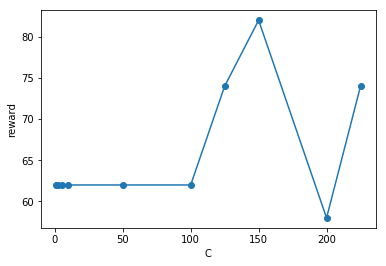

[62, 62, 62, 62, 62, 62, 62, 74, 82, 58, 74]

In [127]:
import matplotlib.pyplot as plt

cashmoney = storerewards #[i for (i,a) in storerewards]
plt.plot(cs,cashmoney,'o-')
plt.xlabel("C")
plt.ylabel("reward")
plt.show()

storerewards

In [123]:
# now let's compare the performance of different computation times (AND C)

storetobservations = []
storetactions = []
storetrewards = []
times = [0.01,0.1,0.5,1.,1.5,2.0,3.0,3.5,4.0]

for t in times:
    print("Computation time = ", t)
    
    # Initialize the tamagotchi
    realtama = Tamagotchi()
    game = Tamagotchi_Game()

    print("INITIAL STATE: ")
    realtama.print_tama() # initial tamagotchi state

    agent = POMCP(game, time = t)

    action_seq = []
    obs_seq = []
    state = tuple(realtama)
    obs = []
    context = {}

    while len(action_seq) <= 1000 and not game.unpack(state).is_dead: # play for a certain amount of time (better rule?)

        legal = game.legal_actions([state])
        action = agent.search(obs,context,legal)
        action_seq.append(action)
        print("Action %i: taking action %s."% (len(action_seq),action))

        obs = game.observation(state,action)
        obs_seq.append(obs)
        if obs ==[]:
            print("No meaningful observation acquired.")
        else:
            print("Agent saw tamagotchi state!")

        state = game.next_state(state,action)
#         if len(action_seq) % 10 == 0:
#             print("\nNumber of actions taken: ",len(action_seq))
#             r,_ = game.reward(state)
#             print("Reward so far: ",r)
#             print("Tama state:")
#             unpack(state).print_tama()

    print("game over!")
    
    storetobservations.append([obs_seq])
    storetactions.append([action_seq])
    r,_ = game.reward(state)
    storetrewards.append(r)
    unpack(state).print_tama()

Computation time =  0.01
INITIAL STATE: 
Time: 0  seconds elapsed
TAMA STATS:  {'happiness': 100, 'energy': 100, 'food': 100, 'health': 100, 'hygiene': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Action 1: taking action nothing.
No meaningful observation acquired.
Action 2: taking action nothing.
No meaningful observation acquired.
Action 3: taking action store.
No meaningful observation acquired.
Action 4: taking action observe.
Agent saw tamagotchi state!
Action 5: taking action observe.
Agent saw tamagotchi state!
Action 6: taking action nothing.
No meaningful observation acquired.
Action 7: taking action observe.
Agent saw tamagotchi state!
Action 8: taking action nothing.
No meaningful observation acquired.
Action 9: taking action nothing.
No meaningful observation acquired.
Action 10: taking action store.
No meaningful observation acquired.
Action 11: taking action nothing.
No meaningful observation

Action 57: taking action snack.
No meaningful observation acquired.
Action 58: taking action observe.
Agent saw tamagotchi state!
Action 59: taking action nothing.
No meaningful observation acquired.
Action 60: taking action observe.
No meaningful observation acquired.
Action 61: taking action nothing.
No meaningful observation acquired.
Action 62: taking action observe.
No meaningful observation acquired.
Action 63: taking action observe.
Agent saw tamagotchi state!
Action 64: taking action observe.
Agent saw tamagotchi state!
Action 65: taking action observe.
Agent saw tamagotchi state!
Action 66: taking action nothing.
No meaningful observation acquired.
game over!
Time: 66  seconds elapsed
Tama is dead!
TAMA STATS:  {'hygiene': 0, 'happiness': 0, 'energy': 32.0, 'food': 0, 'health': 24.0}
Tama is awake.
Tama is sick.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Computation time =  0.5
INITIAL STATE: 
Time: 0  seconds elap

Action 16: taking action observe.
Agent saw tamagotchi state!
Action 17: taking action nothing.
No meaningful observation acquired.
Action 18: taking action nothing.
No meaningful observation acquired.
Action 19: taking action observe.
Agent saw tamagotchi state!
Action 20: taking action store.
No meaningful observation acquired.
Action 21: taking action nothing.
No meaningful observation acquired.
Action 22: taking action nothing.
No meaningful observation acquired.
Action 23: taking action observe.
Agent saw tamagotchi state!
Action 24: taking action nothing.
No meaningful observation acquired.
Action 25: taking action nothing.
No meaningful observation acquired.
Action 26: taking action store.
No meaningful observation acquired.
Action 27: taking action observe.
Agent saw tamagotchi state!
Action 28: taking action nothing.
No meaningful observation acquired.
Action 29: taking action nothing.
No meaningful observation acquired.
Action 30: taking action nothing.
No meaningful observat

Action 2: taking action store.
No meaningful observation acquired.
Action 3: taking action nothing.
No meaningful observation acquired.
Action 4: taking action store.
No meaningful observation acquired.
Action 5: taking action nothing.
No meaningful observation acquired.
Action 6: taking action nothing.
No meaningful observation acquired.
Action 7: taking action observe.
Agent saw tamagotchi state!
Action 8: taking action nothing.
No meaningful observation acquired.
Action 9: taking action play.
No meaningful observation acquired.
Action 10: taking action store.
No meaningful observation acquired.
Action 11: taking action snack.
No meaningful observation acquired.
Action 12: taking action observe.
Agent saw tamagotchi state!
Action 13: taking action observe.
Agent saw tamagotchi state!
Action 14: taking action nothing.
No meaningful observation acquired.
Action 15: taking action nothing.
No meaningful observation acquired.
Action 16: taking action store.
No meaningful observation acqui

Action 50: taking action nothing.
No meaningful observation acquired.
Action 51: taking action store.
No meaningful observation acquired.
Action 52: taking action nothing.
No meaningful observation acquired.
Action 53: taking action observe.
Agent saw tamagotchi state!
Action 54: taking action play.
No meaningful observation acquired.
game over!
Time: 54  seconds elapsed
Tama is dead!
TAMA STATS:  {'hygiene': 0, 'happiness': 0, 'energy': 48.0, 'food': 0, 'health': 40.0}
Tama is asleep.
Number of poo: 0
Money: 5
You're not in the store, so you can play, do nothing, or travel to the store.


Computation time =  3.5
INITIAL STATE: 
Time: 0  seconds elapsed
TAMA STATS:  {'happiness': 100, 'energy': 100, 'food': 100, 'health': 100, 'hygiene': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Action 1: taking action nothing.
No meaningful observation acquired.
Action 2: taking action nothing.
No meaningful observatio

Action 29: taking action store.
No meaningful observation acquired.
Action 30: taking action snack.
No meaningful observation acquired.
Action 31: taking action snack.
No meaningful observation acquired.
Action 32: taking action nothing.
No meaningful observation acquired.
Action 33: taking action store.
No meaningful observation acquired.
Action 34: taking action nothing.
No meaningful observation acquired.
Action 35: taking action nothing.
No meaningful observation acquired.
Action 36: taking action store.
No meaningful observation acquired.
Action 37: taking action nothing.
No meaningful observation acquired.
Action 38: taking action observe.
No meaningful observation acquired.
Action 39: taking action store.
No meaningful observation acquired.
Action 40: taking action nothing.
No meaningful observation acquired.
Action 41: taking action play.
No meaningful observation acquired.
Action 42: taking action observe.
Agent saw tamagotchi state!
Action 43: taking action play.
No meaningfu

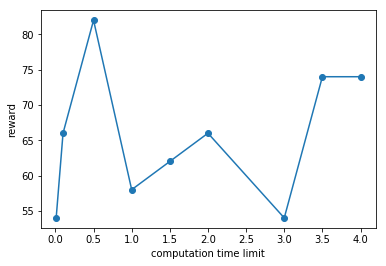

In [124]:
times = [0.01,0.1,0.5,1.,1.5,2.0,3.0,3.5,4.0]
cashtmoney = storetrewards #[i for (i,a) in storetrewards]
plt.plot(times,cashtmoney,'o-')
plt.xlabel("computation time limit")
plt.ylabel("reward")
plt.show()

In [119]:
storetrewards

[74, 66, 58, 66, 74, 79, 74, 79, 62]